<a href="https://colab.research.google.com/github/liadmagen/Modeling_course/blob/main/exercises_notebooks/02_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometric aspects of data

## Introduction
In our previous assignment, we trained two types of classifiers:
- A discrete classifier, a decision tree, which chose the appropriate label from a finite set
- An continuous classifier - linear and logistic regression models that scored or ranked each of the data points.

One way to interpret those classifiers is as a **mapping function** between the data to its label, between each `X` data point to its corresponding `y`.

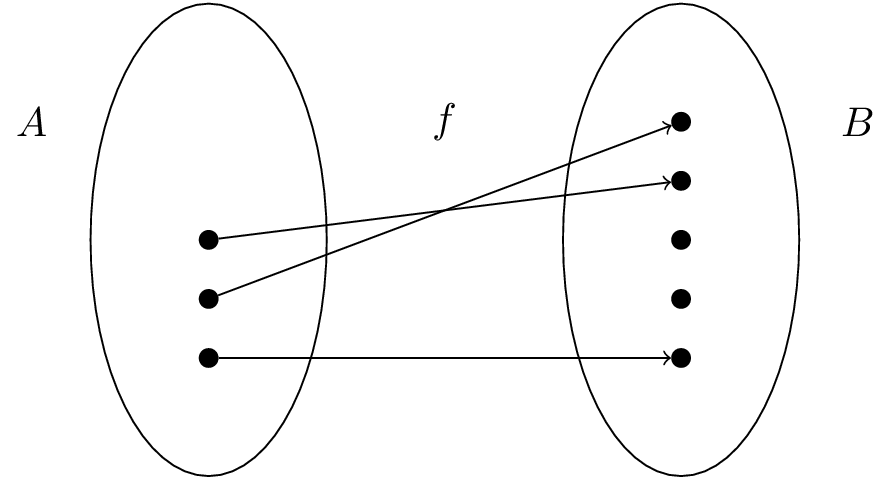

## Data as a vector

We will not always have labels for every data point. Labeling the data may be expensive. It may include hiring people for this purpose, or it may require waiting a long time to examine the results.

For example, in the case of churn prediction, we do not want to wait and test which clients leave the company. It would be better to try to predict it in advance.

Here is an idea - we can imagine our data, our features values, as a set of multi-dimensional points. Adjacent points in this multi-dimensional space may have a similar outcome. We can learn a classifier that given a new data point, will asign its label based on the labels of the other points around it.  

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In this exercise, we will work with [Telco Customer churn data from IBM](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113
).

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

Hhere we will use a smaller version of it, for simplicity.

In [3]:
df = pd.read_csv('https://github.com/liadmagen/Modeling_course/raw/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


we are not interested in the `CustomerID` column, and therefore we will remove it from the dataset:

In [5]:
df.drop(['customerID'], axis=1, inplace=True)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


## Converting columns to numerical values

Previously, when handling Logistic Regression, we had to pre-process our data,  transform and scale it before using it as an input. 
In this dataset, we have a different problem: some of our features are not even numerical.

Computers can only 'understand' numerical values. Therefore, the data we feed into our models must be in a numerical form.

> How can we tackle that?

Pandas treats columns with values such as 'Yes / No' as text columns. They are represented as an 'object' type.

In [7]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We can count how many unique values those columns contain using the method `.value_counts()`.

In [8]:
df['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Let's take a look at all those columns which are not numerical with the `.select_dtypes()` method:

In [8]:
 df.select_dtypes(include=['object'])

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75,No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,1990.5,No
7039,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),7362.9,No
7040,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,346.45,No
7041,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,306.6,Yes


Notice the `TotalCharges` column. This is a numerical value that was not properly parsed. Let's find out why and change it manually to numeric (float).

In [11]:
df['TotalCharges'].value_counts()

           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
4577.9      1
263.05      1
358.05      1
3653.35     1
4492.9      1
Name: TotalCharges, Length: 6531, dtype: int64

The column contains empty values (empty strings). We must fix it before changing the type to numeric.

How can we fix it?
1. we can remove entirely those rows
2. we can fill these values with a numerical value, such as 0.0 or negative value that would represent it to be previously an empty string.


In [12]:
### YOUR TURN: ###
# Choose one of the methods and clean the noisy data points
# Check the method `.str.strip` that removes all white spaces from the cell.
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html





##################

Now with the column cleaned, we are ready to convert it to numerical value:

In [13]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

We will convert the rest of the columns to a `categorical` type, a data type in pandas, made for columns with a limited amount of unique values. It assigns each category a numerical value.

Read more about pandas categorical values here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

In [14]:
# first we store the original as a copy:
df_original = df.copy()

# Then we convert all our categories to numerical values:
for col in  df.select_dtypes(include=['object']).columns:
  df[col] = df[col].astype('category')
  df[col] = df[col].cat.codes

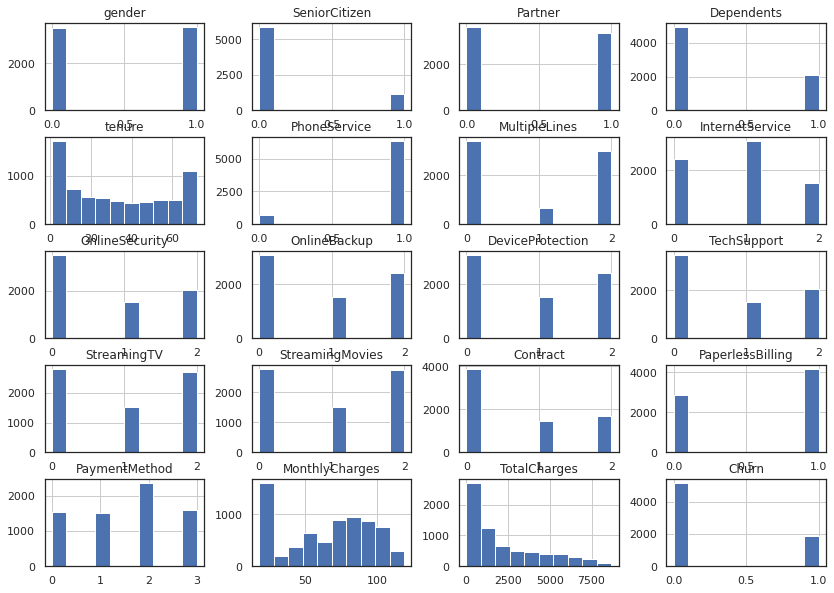

In [15]:
hists = df.hist()

Let's look at some random row as an example:

In [16]:
df.iloc[1234]

gender                 0.00
SeniorCitizen          1.00
Partner                0.00
Dependents             0.00
tenure                16.00
PhoneService           1.00
MultipleLines          2.00
InternetService        1.00
OnlineSecurity         0.00
OnlineBackup           0.00
DeviceProtection       0.00
TechSupport            0.00
StreamingTV            2.00
StreamingMovies        2.00
Contract               0.00
PaperlessBilling       1.00
PaymentMethod          2.00
MonthlyCharges        96.15
TotalCharges        1529.20
Churn                  1.00
Name: 1238, dtype: float64

Now we are ready. Our data is numeric. 

Before moving on, let's start with visualizing the data by projecting it into a 2D space using PCA. You have already done it with R - now it's time to do it with python.

We deliberately remove the Churn column - to simulate the PCA output without revealing it what the result is.

In [36]:
from sklearn.decomposition import PCA

y = df['Churn']
X = df.drop('Churn', axis=1)

reduced_X = PCA(n_components=2).fit_transform(X)

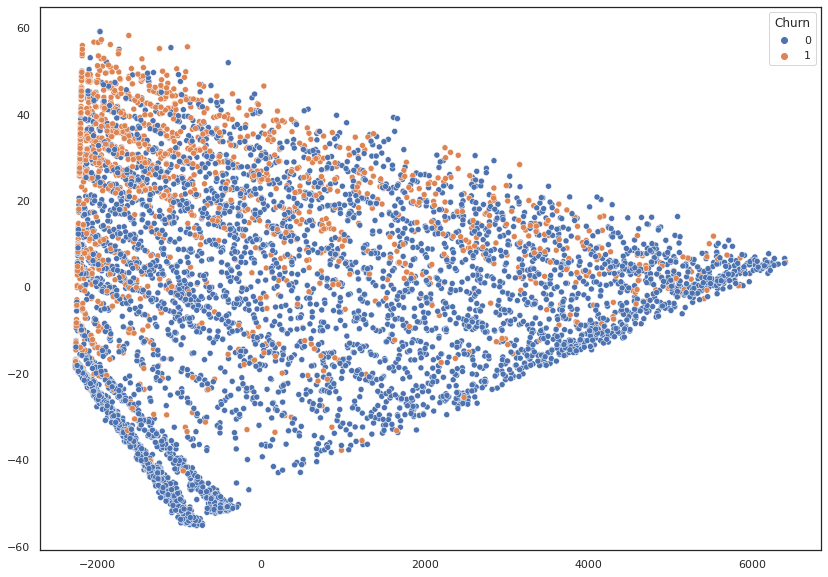

In [37]:
sns.scatterplot(x = reduced_X[:, 0], y=reduced_X[:, 1], hue=y)

# Vector Distance and KNN

Our data now exists in a numerical form. The advantage of having the data as numeric is that we can use a distance metric to calculate how near every point is to the rest of the points in the multi-dimensional space. 

We hope, through it, to get a notion of how similar those points are to each other.

For example, these two data points are relatively similar. Hence we hope they would have the same Churn output.

| Column             | Point 1 | Point 2 |
|--------------------|---------|---------|
| gender             |    0.00 |    1.00 |
| SeniorCitizen      |    1.00 |    1.00 |
| Partner            |    0.00 |    0.00 |
| Dependents         |    0.00 |    0.00 |
| tenure             |   16.00 |   15.00 |
| PhoneService       |    1.00 |    1.00 |
| MultipleLines      |    2.00 |    2.00 |
| InternetService    |    1.00 |    1.00 |
| OnlineSecurity     |    0.00 |    0.00 |
| OnlineBackup       |    0.00 |    0.00 |
| DeviceProtection   |    0.00 |    0.00 |
| TechSupport        |    0.00 |    0.00 |
| StreamingTV        |    2.00 |    2.00 |
| StreamingMovies    |    2.00 |    2.00 |
| Contract           |    0.00 |    0.00 |
| PaperlessBilling   |    1.00 |    1.00 |
| PaymentMethod      |    2.00 |    2.00 |
| MonthlyCharges     |   96.15 |   94.11 |
| TotalCharges       | 1529.20 | 1519.35 |

## How is the distance calculated?
One of the simplest method is the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). For two simple 2D values, e.g., **(2,3)** & **(5,1)**, that would be: $\sqrt{(2-5)^2+(3-1)^2}$

For multiple dimensions, we can use the generalized formula:

$$ d(a, b) = \sqrt{\sum_{i=1}^D (a_i - b_i)^2 } $$


Now, that we have a way to measure how two different points in the space relate to each other, let's think how we can learn 

## K-Nearest Neighbors

The basic notion is this: Adjacent points in this multi-dimensional space should have a similar outcome. 

We can learn a classifier that given a new data point, will calculte the distance to all the other points, and asign its label based on the labels of the nearest points to it.

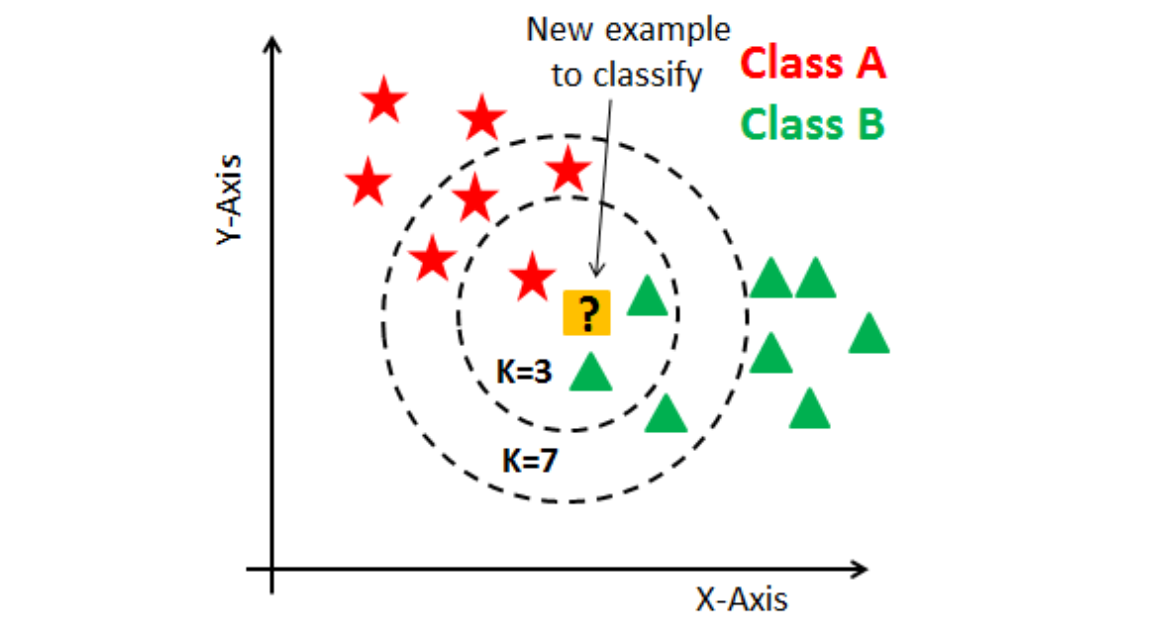

In [34]:
from sklearn.neighbors import KNeighborsClassifier

Let's separate first the data to **train** and **test** sets

In [38]:
#### Your Turn: ####
# Separate the data to training and testing set, as we did in the previous exercise


# X_train, X_test, y_train, y_test = 



####

In [44]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=2)

In [64]:
from sklearn import metrics

print(metrics.classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1711
           1       0.61      0.30      0.40       610

    accuracy                           0.77      2321
   macro avg       0.70      0.61      0.63      2321
weighted avg       0.74      0.77      0.73      2321



However, if we print the true probabilities - we can see that KNN has some points where it is not sure about:

In [60]:
knn.predict_proba(X_test)[:20]

array([[1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [0. , 1. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ]])

In [74]:
# Let's count how many points:
prediction_probabilities = knn.predict_proba(X_test)[:, 0]

np.argwhere(prediction_probabilities == 0.5).shape[0] / len(X_test)

0.2774666092201637

This uncertainty is important. When we need to make decisions based on the data, we need ot know for which values we are sure vs for which we have low certainty.

Let's calculate the metrics only for the 63% of the data which we are sure about.


In [79]:
# get the indeces of the values we are sure about
sure_indeces = np.argwhere(prediction_probabilities != 0.5).squeeze()

# and print the classification report again:
print(metrics.classification_report(y_test.iloc[sure_indeces], knn.predict(X_test.iloc[sure_indeces])))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1279
           1       0.61      0.45      0.52       398

    accuracy                           0.80      1677
   macro avg       0.73      0.68      0.70      1677
weighted avg       0.79      0.80      0.79      1677

